# Efficient Fourier Descriptors Analysis
Using efficient fourier descriptors of the contours to identify sub-populations.

In [2]:
import os
import pandas
import tifffile
import plotly.express as px
import plotly.figure_factory as ff		
import plotly.io as pio
import plotly.graph_objects as go
from sklearn import manifold, cluster, decomposition, metrics, preprocessing
import numpy
import scipy.cluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import ClusterWarning
from matplotlib import pyplot as plt
import matplotlib
from scipy.spatial.distance import squareform
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

pio.renderers.default = "browser" #set the renderer to browser
import pyefd


In [10]:
#set colours
def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)
hex_list = []
for c in px.colors.qualitative.Set1:
	hex_list.append(rgb_to_hex(int(c.replace("rgb(","").replace(")","").split(",")[0]),int(c.replace("rgb(","").replace(")","").split(",")[1]), int(c.replace("rgb(","").replace(")","").split(",")[2])))
 
def plot_dendrogram(model, **kwargs):
	# Create linkage matrix and then plot the dendrogram
	# create the counts of samples under each node
	counts = numpy.zeros(model.children_.shape[0])
	n_samples = len(model.labels_)
	for i, merge in enumerate(model.children_):
		current_count = 0
		for child_idx in merge:
			if child_idx < n_samples:
				current_count += 1  # leaf node
			else:
				current_count += counts[child_idx - n_samples]
		counts[i] = current_count
	linkage_matrix = numpy.column_stack([model.children_, model.distances_, counts]).astype(float)
	# Plot the corresponding dendrogram
	plt.figure(figsize=(2000,2000))
	plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
	plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
	dendrogram(linkage_matrix, **kwargs)

def generate_rand_index(cluster_df : pandas.DataFrame, to_compare : list):
	r_ind = pandas.DataFrame(columns=to_compare, index=to_compare)
	for i in to_compare:
		for j in to_compare:
			r_ind.loc[j,i] = metrics.rand_score(cluster_df[i], cluster_df[j])
	return r_ind

def population_percentages(df : pandas.DataFrame, clustering : str):
	labels = [int(c) for c in df[clustering]]
	counts = [0 for i in range(max(labels)+1)]
	for l in labels:
		counts[l]+=1
	percentages = [c/len(labels) for c in counts]
	return percentages, counts

def analysis(dists : pandas.DataFrame, n_colours : int , cluster_numbers : list,  name : str,  dir : str, group = False, exclude : list = [], show2d = False, showElbow=False, colour_list=hex_list, save=True, show=True):
	#colour order is red, purple, blue, green
	if group == False:
		inds = dists.index
		dists = dists
		if len(exclude) != 0:
			print("Need to exclude: ", exclude)
			inds = []
			for f in dists.index:
				if f not in exclude:
					inds.append(f)
			dists = dists.loc[inds, inds]
			print("now dists has shape: ", dists.shape)
	else:
		inds = []
		for f in dists.index:
			if group in f and f not in exclude:
				inds.append(f)
		dists = dists.loc[inds, inds]
	df = pandas.DataFrame(index=inds)
	embed = manifold.MDS(3, dissimilarity='precomputed', random_state=1, normalized_stress="auto").fit_transform(dists.to_numpy())
	df["x"] = embed[:,0]
	df["y"] = embed[:,1]
	df["z"] = embed[:,2]
	silhouette_samples = []
	silhouette_score = []
	linkage_matrices = []
	avg = cluster.AgglomerativeClustering(distance_threshold=None, n_clusters=n_colours, linkage="average")
	avg = avg.fit(dists.to_numpy())
	dflt = "#000000"
	D_leaf_colors = {dists.index[i]: colour_list[avg.labels_[i]] for i in range(len(avg.labels_))}
	#Average
	for link in ["average", "complete", "single", "ward"]:
		linkage = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=link)
		linkage = linkage.fit(dists.to_numpy())
		counts = numpy.zeros(linkage.children_.shape[0])
		n_samples = len(linkage.labels_)
		for i, merge in enumerate(linkage.children_):
			current_count = 0
			for child_idx in merge:
				if child_idx < n_samples:
					current_count += 1  # leaf node
				else:	
					current_count += counts[child_idx - n_samples]
			counts[i] = current_count
		linkage_matrix = numpy.column_stack([linkage.children_, linkage.distances_, counts]).astype(float)
		linkage_matrices.append(linkage_matrix)
		# notes:
		# * rows in Z correspond to "inverted U" links that connect clusters
		# * rows are ordered by increasing distance
		# * if the colors of the connected clusters match, use that color for link
		link_cols = {}
		for i, i12 in enumerate(linkage_matrix[:,:2].astype(int)):
			c1, c2 = (link_cols[x] if x > len(linkage_matrix) else D_leaf_colors[dists.index[x]] for x in i12)
			if c1 == c2:
				link_cols[i+1+len(linkage_matrix)] = c1
			else:
				if i12[0] < n_samples:
					link_cols[i+1+len(linkage_matrix)] = D_leaf_colors[dists.index[i12[0]]]
				elif i12[1] < n_samples:
					link_cols[i+1+len(linkage_matrix)] = D_leaf_colors[dists.index[i12[1]]]
				else:
					link_cols[i+1+len(linkage_matrix)] = dflt
		# Dendrogram
		D = dendrogram(Z=linkage_matrix, labels=dists.index, color_threshold=None, no_labels=True, link_color_func=lambda x: link_cols[x])
		#plt.xlabel(name+" "+link)
		plt.yticks([])
		if save:
			plt.savefig(dir+"/"+name.replace(" ","_")+"_"+link+"_dendrogram.png")
		plt.show()
	sse = []
	for link in ["average", "complete", "single", "ward"]:
		for k in cluster_numbers:
			linkage = cluster.AgglomerativeClustering(distance_threshold=None, n_clusters=k, linkage=link)
			linkage = linkage.fit(dists.to_numpy())
			labels = linkage.labels_
			labels = [str(c) for c in labels]
			df[link+str(k)] = labels
			sil_score = metrics.silhouette_score(dists, df[link+str(k)], metric="precomputed")
			silhouette_score.append(sil_score)
			sil_samps = metrics.silhouette_samples(dists, df[link+str(k)], metric="precomputed")
			silhouette_samples.append([sil_samps])
			fig = px.scatter(df, x='x', y='y',color=link+str(k), title=name+" ("+link+" "+str(k)+")", hover_data=[df.index], width=800, height=600, color_discrete_map={
                "0": hex_list[0], "1": hex_list[1],"2": hex_list[1],"2": hex_list[2], "3": hex_list[3]})
			fig.update_traces(marker={'size': 5})
			if show2d:
				fig.show()
			fig.write_image(dir+"/"+name.replace(" ","_")+"_"+link+str(k)+"_2D.png")
	if showElbow:
		plt.plot(cluster_numbers, sse)
		plt.title("Elbow Method")
		plt.xlabel("Number of Clusters")
		plt.xticks(cluster_numbers)
		plt.ylabel("SSE")
		plt.savefig(dir+"/"+name.replace(" ","_")+"_kmeans-elbow.png")
		fig.show()
	df.to_csv(dir+"/"+name.replace(" ","_")+"_df.csv")
	rand_ind_tables_latex = []
	percentages_dict = {}
	for k in cluster_numbers:
		rand_ind_tables_latex.append(generate_rand_index(df, ["average"+str(k), "complete"+str(k), "single"+str(k),"ward"+str(k)]).to_latex())
		print("cluster sizes and percentages are:")
		percentages_dict["average{}".format(k)], counts = population_percentages(df, "average"+str(k))
		print("average{}".format(k), counts, percentages_dict["average{}".format(k)])
		percentages_dict["complete{}".format(k)], counts = population_percentages(df, "complete"+str(k))
		print("complete{}".format(k), counts, percentages_dict["complete{}".format(k)])
		percentages_dict["single{}".format(k)], counts = population_percentages(df, "single"+str(k))
		print("single{}".format(k), counts, percentages_dict["single{}".format(k)])
		percentages_dict["ward{}".format(k)], counts = population_percentages(df, "ward"+str(k))
		print("ward{}".format(k), counts, percentages_dict["ward{}".format(k)])
		#percentages_dict["kmeans++{}".format(k)] = population_percentages(df, "kmeans++"+str(k))
		#print("kmeans++{}".format(k), percentages_dict["kmeans++{}".format(k)])
	return df, silhouette_score, silhouette_samples, rand_ind_tables_latex, percentages_dict, dists, linkage_matrices

def get_main_population(analysis, cluster : str, dists : pandas.DataFrame):
	main_id = analysis[4][cluster].index(max(analysis[4][cluster]))
	main_index= analysis[0].index[analysis[0][cluster] == str(main_id)]
	return dists.loc[main_index,main_index]

def purity(merges, clus : set, n_objs):
	dct = dict([(i, {i}) for i in range(n_objs)])
	for i, row in enumerate(merges, n_objs):
		dct[i] = dct[row[0]].union(dct[row[1]])
		del dct[row[0]]
		del dct[row[1]]
		for c in list(dct.values()):
			if clus.issubset(c):
				return c, (n_objs-len(c))/(n_objs-len(clus))


In [3]:
dataset = "X1+Y1" #select the dataset to analyse and the set the correct width and height of the images
if dataset == "X1":
	width=1500 #we need to set the largest width of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
	height=1692 #we need to set the largest height of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
	scale_factor = 0.3155
	files = os.listdir(dataset+"/cell/raw_images")
	cell_names = [int(file[0:3]) for file in files if file.endswith('.tif')]
elif dataset == "X2":
	width=1455
	height=1584
	scale_factor = 0.3155
	files = os.listdir(dataset+"/cell/raw_images")
	cell_names = [int(file[0:3]) for file in files if file.endswith('.tif')]
elif dataset == "X3":
	width=1919
	height=1467
	scale_factor = 0.3155
	files = os.listdir(dataset+"/cell/raw_images")
	cell_names = [int(file[0:3]) for file in files if file.endswith('.tif')]
elif dataset == "Y1":
	width=1226 #we need to set the largest width of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
	height=1088 #we need to set the largest height of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
	scale_factor = 0.1639
	files = os.listdir(dataset+"/cell/raw_images")
	cell_names = [int(file[0:3]) for file in files if file.endswith('.tif')]
elif dataset == "X1+Y1":
	width_X1 = 1500
	height_X1 = 1692
	scale_factor_X1 = 0.3155
	width_Y1 = 1226
	height_Y1 = 1088
	scale_factor_Y1 = 0.1639
	files_X1 = os.listdir("X1/cell/raw_images")
	files_Y1 = os.listdir("Y1/cell/raw_images")
	cell_names_X1 = ["X1_"+str(int(file[0:3])) for file in files_X1 if file.endswith('.tif')]
	cell_names_Y1 = ["Y1_"+str(int(file[0:3])) for file in files_Y1 if file.endswith('.tif')]
	files = []
	files.extend(files_X1)
	files.extend(files_Y1)
	cell_names = []
	cell_names.extend(cell_names_X1)
	cell_names.extend(cell_names_Y1)
else:
	raise ValueError("Dataset not supported")

n_cells = len(cell_names)

In [6]:
fourier_descriptors = []
for name in cell_names:
	if "X1_" in name:
		i = int(name.split("_")[1])
		ds = "X1"
	elif "Y1_" in name:
		i = int(name.split("_")[1])
		ds = "Y1"
	c = pandas.read_csv(ds+"/cell/contours/"+str("%03d" % i)+"_contour.csv",header=None).to_numpy()
	fd = pyefd.elliptic_fourier_descriptors(c, order=100)
	fourier_descriptors.append(fd)

In [14]:
# Compute distances using different orders
orders = [10, 50, 100]
distances_by_order = {}
fourier_descriptors_by_order = {}
for order in orders:
	# Extract Fourier descriptors for this order
	fd_order = []
	for name in cell_names:
		if "X1_" in name:
			i = int(name.split("_")[1])
			ds = "X1"
		elif "Y1_" in name:
			i = int(name.split("_")[1])
			ds = "Y1"
		else:
			i = int(name)
			ds = dataset
		c = pandas.read_csv(ds+"/cell/contours/"+str("%03d" % i)+"_contour.csv",header=None).to_numpy()
		fd = pyefd.elliptic_fourier_descriptors(c, order=order)
		fd_order.append(fd)
	fourier_descriptors_by_order[order] = fd_order
	# Reshape to 2D array
	fd_array = numpy.array(fd_order).reshape(len(fd_order), -1)
	
	# Compute pairwise distances
	from scipy.spatial.distance import pdist, squareform
	dist_matrix = squareform(pdist(fd_array, metric='euclidean'))
	
	# Store as DataFrame
	distances_by_order[order] = pandas.DataFrame(dist_matrix, index=cell_names, columns=cell_names)



In [16]:
dists_10 = pandas.DataFrame(distances_by_order[10], index=cell_names, columns=cell_names)
dists_50 = pandas.DataFrame(distances_by_order[50], index=cell_names, columns=cell_names)
dists_100 = pandas.DataFrame(distances_by_order[100], index=cell_names, columns=cell_names)


In [32]:
dists_10.to_csv("X1+Y1/efd-analysis/dists_10.csv")
dists_50.to_csv("X1+Y1/efd-analysis/dists_50.csv")
dists_100.to_csv("X1+Y1/efd-analysis/dists_100.csv")


In [25]:
len(fourier_descriptors_by_order[10])

240

Variance explained by each component:
PC1: 0.453
PC2: 0.165
PC3: 0.124
PC4: 0.090
PC5: 0.034
PC6: 0.028
PC7: 0.017
PC8: 0.013
PC9: 0.011
PC10: 0.009

Cumulative variance explained:
First 1 PCs: 0.453
First 2 PCs: 0.618
First 3 PCs: 0.742
First 4 PCs: 0.832
First 5 PCs: 0.866
First 6 PCs: 0.894
First 7 PCs: 0.910
First 8 PCs: 0.923
First 9 PCs: 0.934
First 10 PCs: 0.943


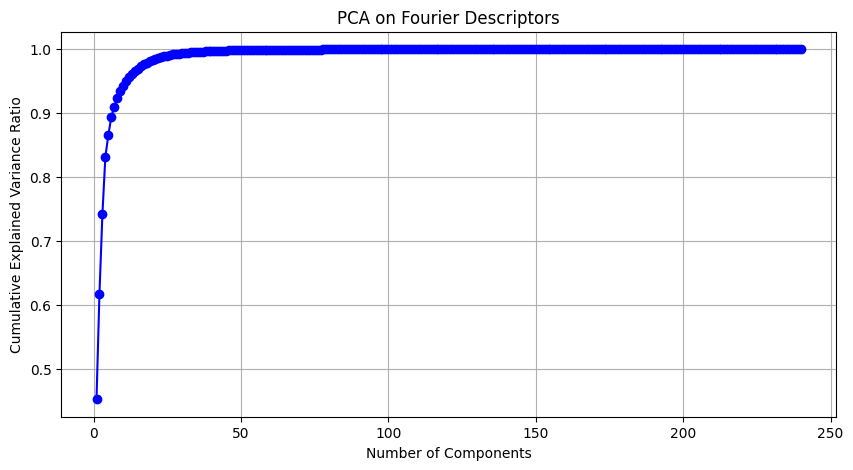

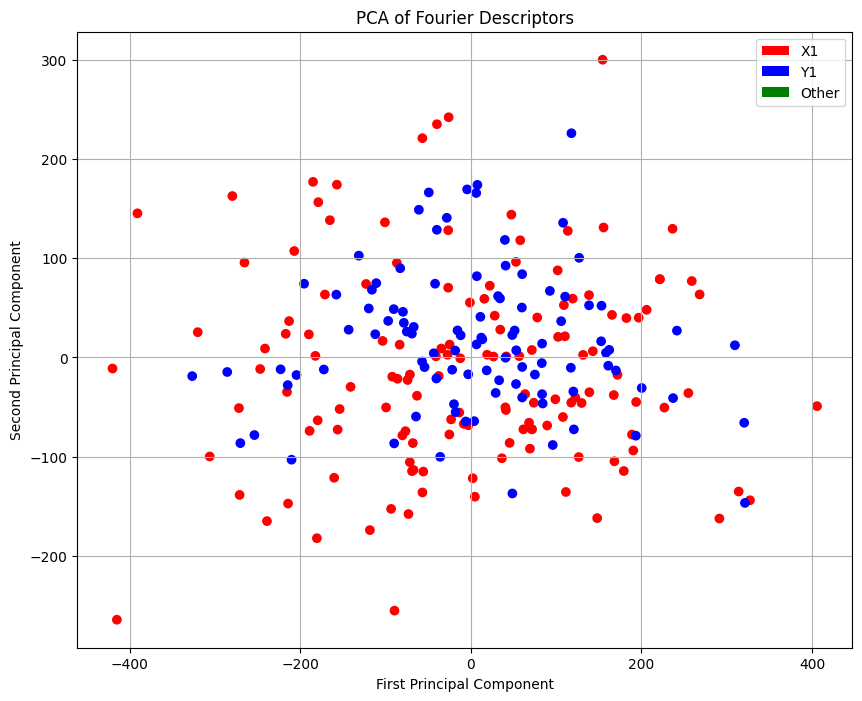

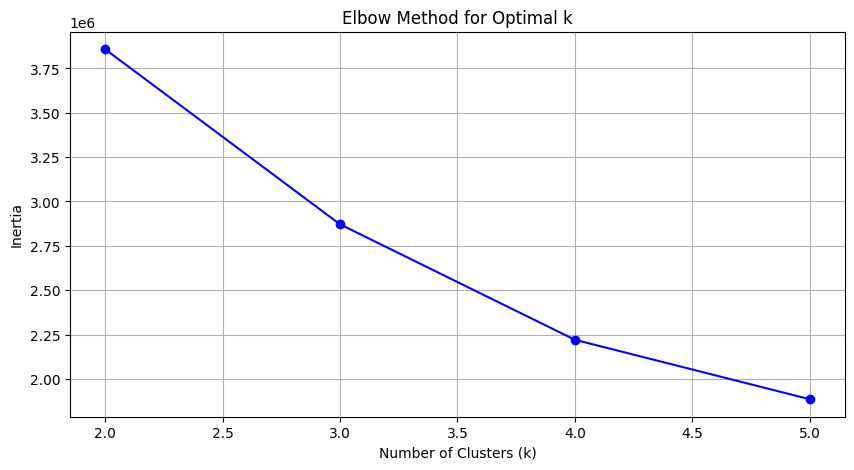

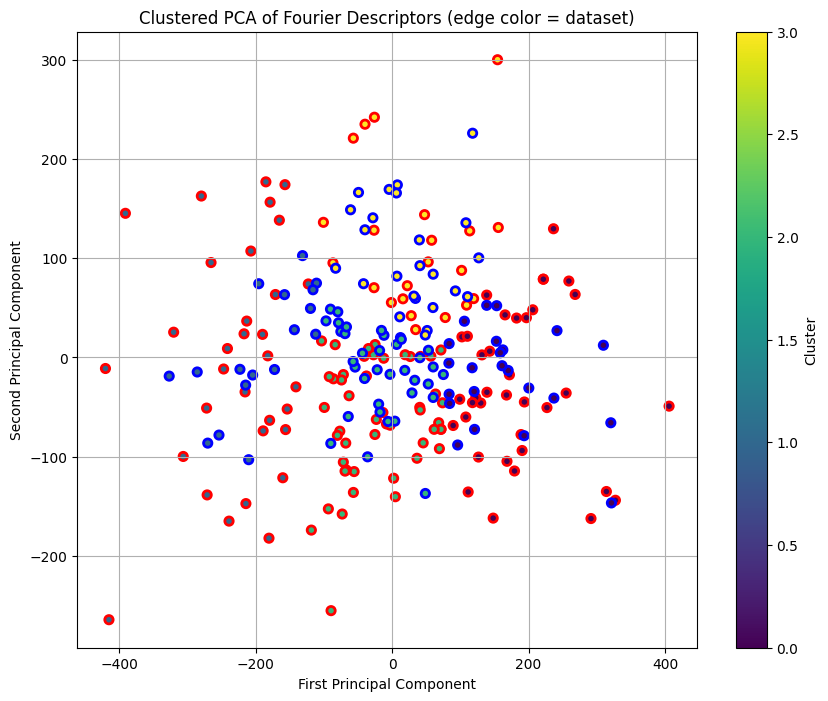

In [31]:
# Reshape the Fourier descriptors into a 2D array
fd_array = numpy.array(fourier_descriptors_by_order[100]).reshape(len(fourier_descriptors_by_order[100]), -1)

# Perform PCA
from sklearn.decomposition import PCA

pca = PCA()
fd_pca = pca.fit_transform(fd_array)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = numpy.cumsum(explained_variance_ratio)

# Print variance explained by components
print("Variance explained by each component:")
for i, var in enumerate(explained_variance_ratio[:10]):
    print(f"PC{i+1}: {var:.3f}")

print("\nCumulative variance explained:")
for i, cum_var in enumerate(cumulative_variance_ratio[:10]):
    print(f"First {i+1} PCs: {cum_var:.3f}")

# Plot explained variance ratio
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA on Fourier Descriptors')
plt.grid(True)
plt.show()

# Create color labels based on dataset (X1 or Y1)
colors = []
for name in cell_names:
    if "X1_" in name:
        colors.append('red')
    elif "Y1_" in name:
        colors.append('blue')
    else:
        colors.append('green')

# Create a scatter plot of the first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(fd_pca[:, 0], fd_pca[:, 1], c=colors)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Fourier Descriptors')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', label='X1'),
                   Patch(facecolor='blue', label='Y1'),
                   Patch(facecolor='green', label='Other')]
plt.legend(handles=legend_elements)
plt.grid(True)
plt.show()

# Perform K-means clustering on PCA results
from sklearn.cluster import KMeans

# Try different numbers of clusters
n_clusters_range = range(2, 6)
inertias = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(fd_pca[:, :2])  # Using first 2 PCs
    inertias.append(kmeans.inertia_)

# Plot elbow curve to help determine optimal number of clusters
plt.figure(figsize=(10, 5))
plt.plot(n_clusters_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Apply K-means with chosen number of clusters (using k=3 as example)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(fd_pca[:, :2])

# Plot clusters with dataset colors
plt.figure(figsize=(10, 8))
scatter = plt.scatter(fd_pca[:, 0], fd_pca[:, 1], c=clusters, cmap='viridis', edgecolors=colors, linewidths=2)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clustered PCA of Fourier Descriptors (edge color = dataset)')

plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


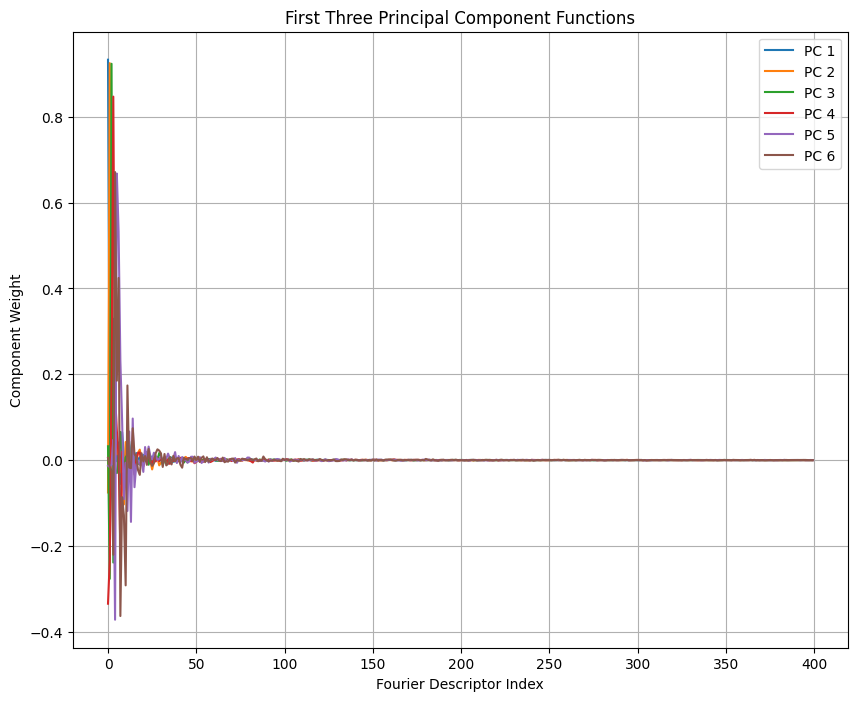

In [33]:
# Plot the first few principal component functions
plt.figure(figsize=(10, 8))

# Get the components from the PCA object
components = pca.components_

# Plot first 3 principal components
for i in range(6):
    plt.plot(components[i], label=f'PC {i+1}')

plt.xlabel('Fourier Descriptor Index')
plt.ylabel('Component Weight')
plt.title('First Three Principal Component Functions')
plt.legend()
plt.grid(True)
plt.show()


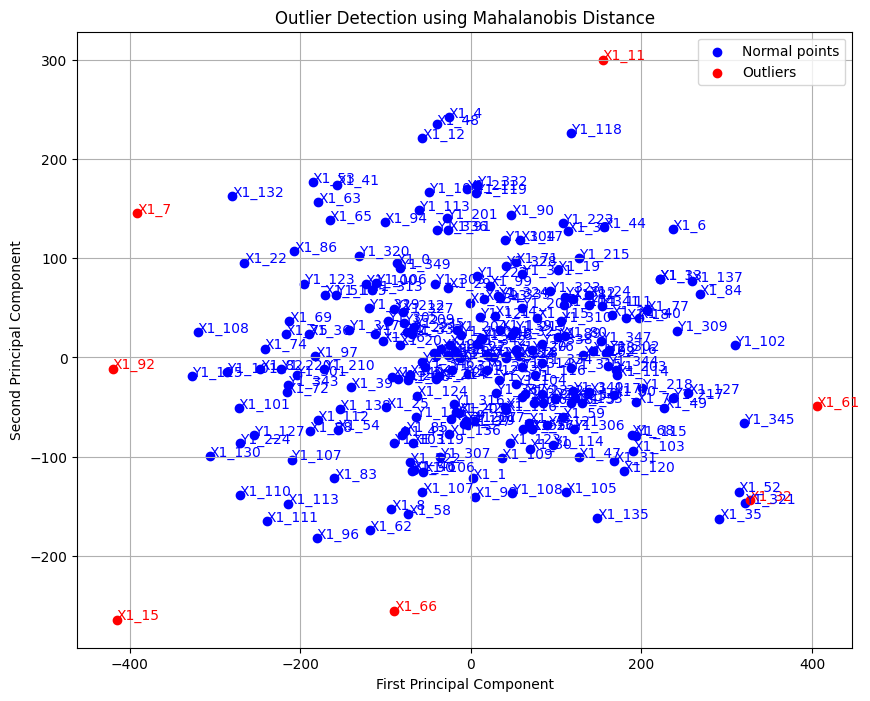


Outlier cells:
['X1_66', 'X1_61', 'X1_11', 'X1_7', 'X1_15', 'X1_32', 'X1_92']


In [35]:
# Calculate Mahalanobis distances for outlier detection
from scipy.stats import chi2

# Calculate mean and covariance of the PCA data
mean = numpy.mean(fd_pca[:, :2], axis=0)
covariance = numpy.cov(fd_pca[:, :2].T)

# Calculate Mahalanobis distances
def mahalanobis(x, mean, cov):
    diff = x - mean
    inv_covmat = numpy.linalg.inv(cov)
    left = numpy.dot(diff, inv_covmat)
    mahal = numpy.dot(left, diff.T)
    return numpy.sqrt(mahal)

mahalanobis_dist = numpy.array([mahalanobis(x, mean, covariance) for x in fd_pca[:, :2]])

# Define threshold for outliers (e.g., 97.5th percentile of chi-square distribution)a
threshold = numpy.sqrt(chi2.ppf(0.975, df=2))  # df=2 because we're using 2 PCA components

# Identify outliers
outliers = mahalanobis_dist > threshold

# Plot results
plt.figure(figsize=(10, 8))
plt.scatter(fd_pca[~outliers, 0], fd_pca[~outliers, 1], c='blue', label='Normal points')
plt.scatter(fd_pca[outliers, 0], fd_pca[outliers, 1], c='red', label='Outliers')

# Add cell number labels
for i, cell in enumerate(cell_names):
    color = 'red' if outliers[i] else 'blue'
    plt.annotate(str(cell), (fd_pca[i, 0], fd_pca[i, 1]), color=color)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Outlier Detection using Mahalanobis Distance')
plt.legend()
plt.grid(True)
plt.show()

# Print outlier information
print("\nOutlier cells:")
outlier_cells = [cell for i, cell in enumerate(cell_names) if outliers[i]]
print(outlier_cells)


In [11]:
# Hierarchical clustering on PCA scores
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.preprocessing import StandardScaler

# Choose number of PCs to retain (e.g., cover 95% variance)
variance_threshold = 0.95
num_pcs = int(numpy.searchsorted(numpy.cumsum(pca.explained_variance_ratio_), variance_threshold) + 1)

# Use the selected PCs' scores
scores = fd_pca[:, :num_pcs]

# Standardize scores before clustering (good practice for Ward)
scaler = StandardScaler()
scores_std = scaler.fit_transform(scores)

# Perform hierarchical clustering (Ward linkage on Euclidean distances)
linkage = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="ward")
# Z = linkage(scores_std, method='ward', n_clusters=4)

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, no_labels=True, color_threshold=0)
plt.title(f'Hierarchical Clustering Dendrogram (Ward) with {k} clusters')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Cut the dendrogram to obtain cluster labels
k = 4  # adjust as needed
labels_hc = fcluster(Z, t=k, criterion='maxclust')

# Scatter of first two PCs colored by hierarchical clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(fd_pca[:, 0], fd_pca[:, 1], c=labels_hc, cmap='tab10')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA scores colored by hierarchical clusters (Ward)')

# Annotate with cell ids
for i, cell in enumerate(cell_names):
    plt.annotate(str(cell), (fd_pca[i, 0], fd_pca[i, 1]), fontsize=8)

plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

# Optional: collect results
hc_results = pandas.DataFrame({
    'cell': cell_names,
    'cluster_ward_k4': labels_hc
})

hc_results.head()


NameError: name 'Z' is not defined

<Figure size 1200x600 with 0 Axes>